# Reason for this test #

### Documentation of an idea ###

The point of adding the last fcost constraint expression, which is trivial anyways because it comes from <b>1</b> - <b>2</b> - <b>3</b>, is that these contraints then can be changed easily when changing the destination node. Just change the RHS of the constraint equations, that is subtract 1 or 0 accordingly.

In [1]:
from pyqubo import Array,Constraint,Placeholder

In [2]:
edges = [(1,2),(1,3),(3,4), (4,2)]
weights = [5,8,4,3]
nodes = 4
x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

In [3]:
print(x.shape)
print(x)
y = (4*x[0]+x[1])
print(y)

(4,)
Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]')])
((4.000000 * Binary('x[0]')) + Binary('x[1]'))


In [5]:
# model = ((x[0] + x[1] - 1)).compile()
# print(model.to_qubo())

In [18]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 100 # chosen arbitrarily. It represents the penalty for the constraints. Also another parameter that can be varied

## Constraints ##
fcost += p*((x[0] + x[1] - 1)**2) 
fcost += p*((x[0] + x[3] - 1)**2)
fcost += p*((x[1] - x[2] - 0)**2)
fcost += p*((x[2] - x[3] - 0)**2)

In [19]:
model = fcost.compile()

In [8]:
print(model.to_qubo())

({('x[1]', 'x[1]'): 8.0, ('x[3]', 'x[0]'): 2.0, ('x[2]', 'x[1]'): -2.0, ('x[1]', 'x[0]'): 2.0, ('x[3]', 'x[3]'): 3.0, ('x[2]', 'x[2]'): 6.0, ('x[2]', 'x[3]'): -2.0, ('x[0]', 'x[0]'): 3.0}, 2.0)


In [20]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': 2.5, 'x[1]': 4.0, 'x[2]': 2.0, 'x[3]': 1.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 50.0, ('x[0]', 'x[3]'): 50.0, ('x[1]', 'x[2]'): -50.0, ('x[2]', 'x[3]'): -50.0}


### So making these changes to the fcost constraint expressions did not have any change to the QUBO model generated, which checks out ###

## Modified Network ##

### Node 2 is the destination node ###

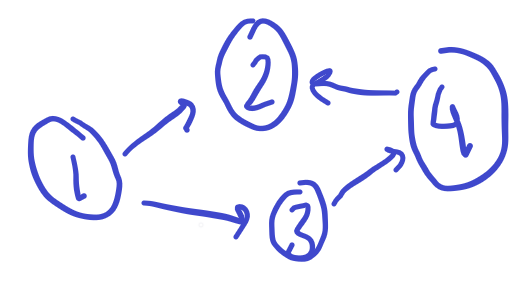

In [14]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [15]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [13]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))

        circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
        
    return circuit

* <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [11]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= shots
    # print(expectation)
    return expectation

In [12]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = create_circuit(beta, gamma)
    
    shots = 10000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    
    return compute_expectation(counts, shots)    

In [21]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [5, 4.0],
               method='COBYLA')
print(res)

     fun: 8.2258
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([5.52344965, 3.83207241])


## Analyzing the Results

In [22]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(0.28517317, -5.05969577)

device = LocalSimulator()
result = device.run(circuit, shots = 1000).result()
counts = result.measurement_counts

print(counts)

# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

Counter({'1011': 188, '1110': 106, '0110': 101, '0001': 100, '0000': 93, '0101': 85, '1000': 79, '1100': 73, '0010': 41, '1101': 39, '0111': 33, '0011': 21, '0100': 13, '1001': 11, '1111': 9, '1010': 8})


In [23]:
print(weights)

[5, 8, 4, 3]


### So adding an outgoing path from Node 4 does change quite a lot, the probabilities are a lot less concrete than without the last path ###
Increasing the number of shots may help in the counts

Now lets try making Node 2 as the destination node